In [10]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
datapath = f'/g/data/fy29/mjl561/cylc-run/rns_ostia_2019_bushfire/netcdf'

In [4]:
variable = 'stratiform_rainfall_flux'

In [5]:
da1 = xr.open_dataset(f'{datapath}/{variable}/E5L_1_CCI_WC_{variable}.nc')[variable]

In [14]:
da1_local = da1.copy()
da1_local['time'] = da1['time'] + pd.Timedelta(hours=10)

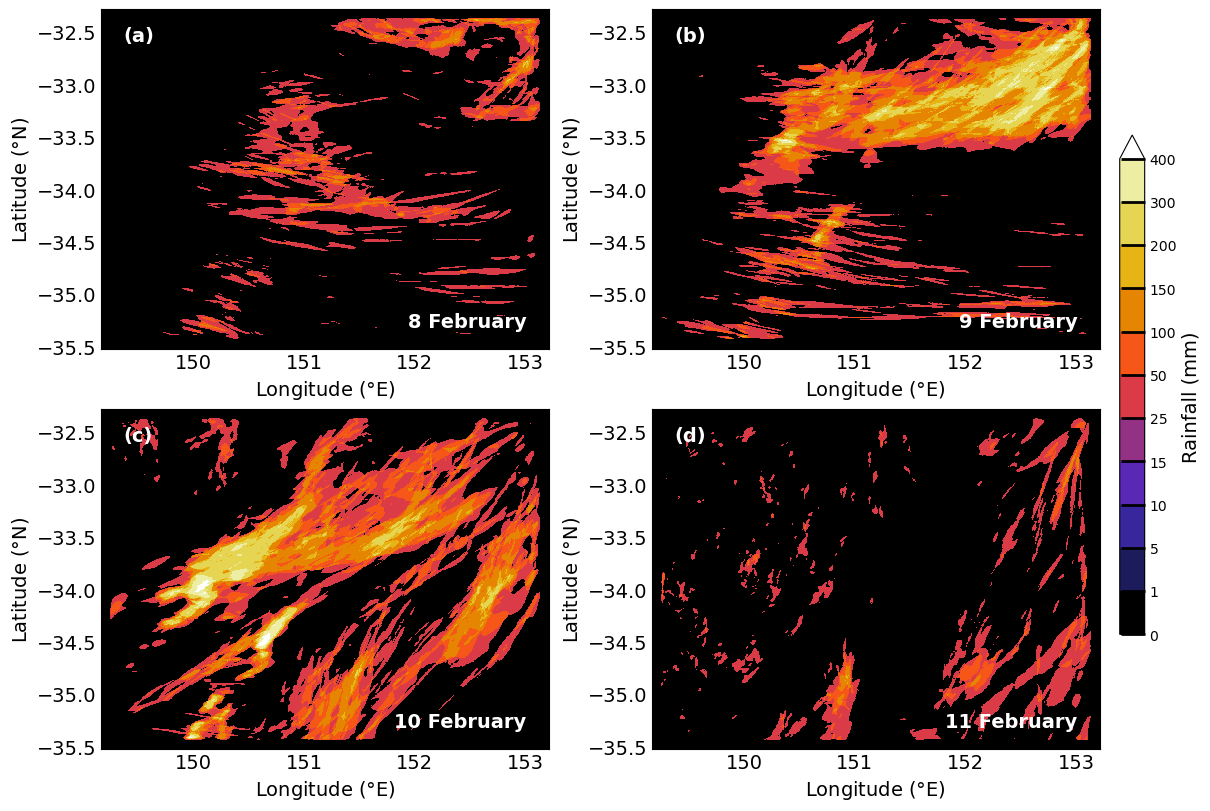

In [20]:
dates = ["2020-02-08", "2020-02-09", "2020-02-10", "2020-02-11"]
titles = ["8 February", "9 February", "10 February", "11 February"]
labels = ['a', 'b', 'c', 'd']
levels = [0, 1, 5, 10, 15, 25, 50, 100, 150, 200, 300, 400]

draft = True 

fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axes = axes.flatten()

for i, date in enumerate(dates):
    day = pd.Timestamp(date)
    
    #9am the day before to 8am on the day
    start_time = day - pd.Timedelta(days=1) + pd.Timedelta(hours=9)
    end_time = day + pd.Timedelta(hours=8)
    
    #convert flux (mm/s) to mm/hr, then sum
    hourly = da1_local.sel(time=slice(start_time, end_time)) * 3600  # convert to mm/hr
    daily_total = hourly.sum(dim='time', skipna=True)

    im = daily_total.plot(
        ax=axes[i],
        cmap='CMRmap',
        levels=levels,
        extend='max',
        add_colorbar=False
    )
    
    axes[i].set_title("")
    axes[i].text(
        0.05, 0.95, f"({labels[i]})",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
        color='white' 
    )
    axes[i].text(
        0.95, 0.05, f"{titles[i]}",
        transform=axes[i].transAxes,
        fontsize=14,
        fontweight='bold',
        va='bottom',
        ha='right',
        color='white' 
    )
    axes[i].set_xlabel("Longitude ($\\degree$E)", fontsize=14)
    axes[i].set_ylabel("Latitude ($\\degree$N)", fontsize=14)
    axes[i].tick_params(axis='both', direction='in', labelsize=14)

cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label("Rainfall (mm)", fontsize=14)
cbar.set_ticks(levels)
cbar.ax.tick_params(axis='y', width=2, direction='in', length=17)

if draft ==False:
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/model_recreation_control.png')
    plt.savefig('/g/data/ng72/as9583/8_to_11_Feb_rain_event/model_recreation_control.pdf', dpi = 300)
